In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataset import NCFDataset
from recom_ncf import NCFRecommender
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/review-clean.csv')[['user_idx', 'item_idx', 'rating_imp', 'timestamp', 'review']]
df.head()

,user_idx,item_idx,rating_imp,timestamp,review
0,0,0,1,1738278781,A legendary tactical shooter that shaped the g...
1,1,0,1,1736206418,"The best CS sure, but server browser is the il..."
2,2,0,1,1738041574,Some of the best memories of my childhood were...
3,3,0,1,1738015332,This game feels so much better than CS2. I kno...
4,4,0,1,1737853720,its very fun to play you can make friends out ...


## Splitting the data

In [3]:
df_train_val, df_test = train_test_split(df[['user_idx', 'item_idx', 'rating_imp']], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=(0.1/0.9), random_state=42)

train_dataset = NCFDataset(df_train)
val_dataset = NCFDataset(df_val)
test_dataset = NCFDataset(df_test)

train_dataloader = DataLoader(train_dataset, batch_size=8192, shuffle=True)
eval_dataloader = DataLoader(val_dataset, batch_size=8192, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8192, shuffle=False)

unique_users = df["user_idx"].unique()
unique_items = df["item_idx"].unique()

In [ ]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1413153, 3)
(176645, 3)
(176645, 3)


## Train model

In [ ]:
model = NCFRecommender(unique_users, unique_items, epochs=1, factors=64, layers=[128, 64, 32, 16])
model.fit(train_dataloader, eval_dataloader)

Epoch 1/1
Train loss: 0.694029, Validation loss: 0.683330
Training completed!


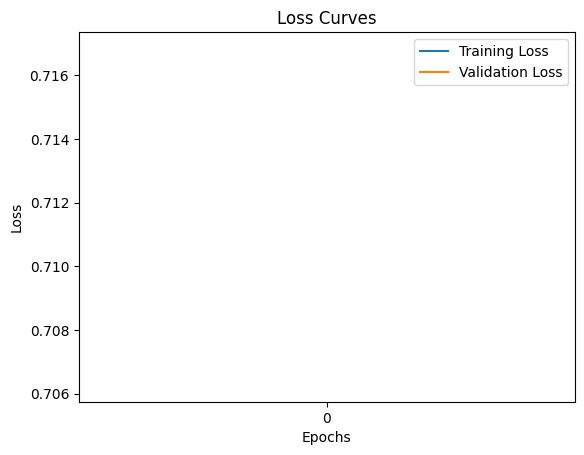

In [ ]:
train_losses = model.train_losses
eval_losses = model.eval_losses
epochs = model.epochs

plt.plot(range(0, epochs), train_losses, label="Training Loss")
plt.plot(range(0, epochs), eval_losses, label="Validation Loss")
plt.xticks(ticks=np.arange(0, epochs + 1, 2))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

In [ ]:
model.save('models/test-model.pt')

In [5]:
from evaluation import Evaluation
evaluator = Evaluation(recommender=model, test_data=df_test)
evaluator.evaluate()

Starting evaluation preparation...
Creating ground truth sets for 149008 users...
Generating predictions...
Processing user batch 1/146 (1024 users)
  - Item batch 1/9
GPU Memory: Reserved=19.31GB, Usage=2.41
High memory usage detected! Reduced batch sizes: users=512, items=4096
  - Item batch 3/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 4/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 5/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 6/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 7/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 8/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 9/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 10/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 11/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 12/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 13/17
GPU Memory: Reserved=10.29GB, Usage=1.29
  - Item batch 14/17
GPU Memory: Reserved=10.

{'Hit Ratio@10': 0.000140932030495007,
 'NDCG@10': 6.291587442916748e-05,
 'Recall@10': 0.00013422098142381618}

In [4]:
from tuner import NCFTuner

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    unique_users=unique_users,
    unique_items=unique_items
)

In [ ]:
results, file_path = tuner.perform_random_search(num_trials=5)

Running experiment with params: {'factors': 16, 'layers': [128, 64, 32, 16], 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 16384, 'optimizer': 'adagrad', 'dropout': 0.0, 'weight_decay': 1e-05, 'loss_fn': 'bpr'}
Epoch 1/10
Train loss: 0.654940, Validation loss: 0.598469
Epoch 2/10
Train loss: 0.549954, Validation loss: 0.511094
Epoch 3/10
Train loss: 0.494705, Validation loss: 0.480927
Epoch 4/10
Train loss: 0.476593, Validation loss: 0.471099
Epoch 5/10
Train loss: 0.470153, Validation loss: 0.467126
Epoch 6/10
Train loss: 0.467008, Validation loss: 0.464933
Epoch 7/10
Train loss: 0.464907, Validation loss: 0.463386
Epoch 8/10
Train loss: 0.463454, Validation loss: 0.462144
Epoch 9/10
Train loss: 0.462073, Validation loss: 0.461069
Epoch 10/10
Train loss: 0.460795, Validation loss: 0.460112
Training completed!
Starting evaluation preparation...
Creating ground truth sets for 149008 users...
Generating predictions...
Processing user batch 1/146 (1024 users)
  - Item batch 1/9
GPU 

In [ ]:
best_params = tuner.analyze_results(results_file=file_path)
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 8, 'layers': [64, 32, 16, 8], 'learning_rate': 0.01, 'epochs': 1, 'batch_size': 4096, 'optimizer': 'adagrad', 'dropout': 0.5, 'weight_decay': 1e-05, 'loss_fn': 'bce'}, 'value': 0.0014294534521636423}, 'NDCG@10': {'params': {'factors': 8, 'layers': [64, 32, 16, 8], 'learning_rate': 0.01, 'epochs': 1, 'batch_size': 4096, 'optimizer': 'adagrad', 'dropout': 0.5, 'weight_decay': 1e-05, 'loss_fn': 'bce'}, 'value': 0.0004636445145402547}, 'Recall@10': {'params': {'factors': 8, 'layers': [64, 32, 16, 8], 'learning_rate': 0.01, 'epochs': 1, 'batch_size': 4096, 'optimizer': 'adagrad', 'dropout': 0.5, 'weight_decay': 1e-05, 'loss_fn': 'bce'}, 'value': 0.0013765824309553505}}


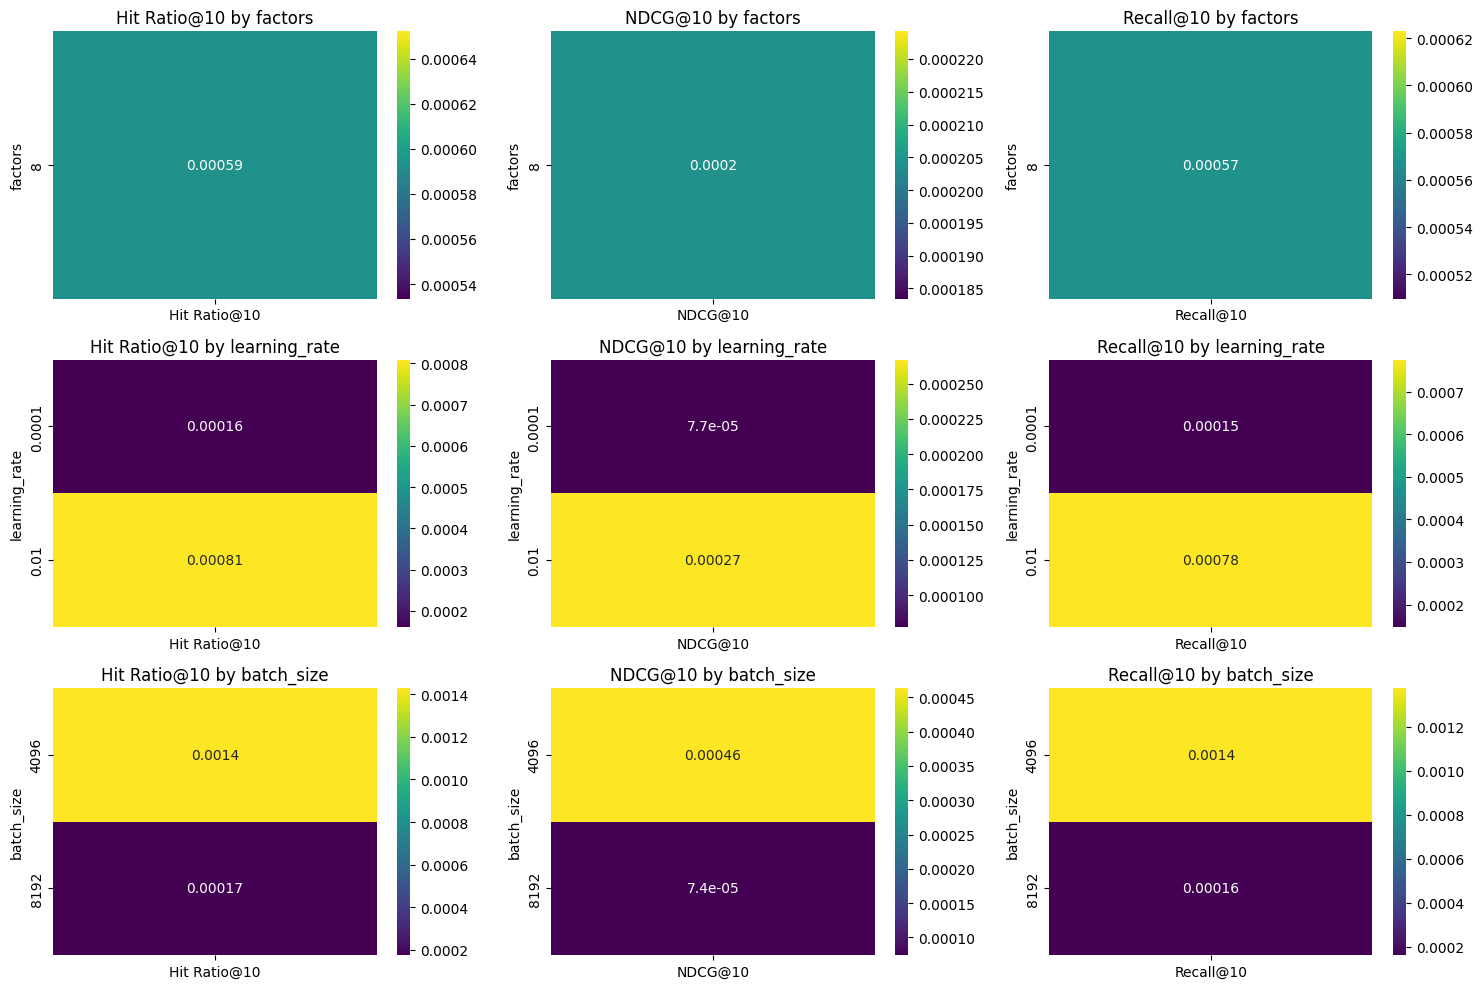

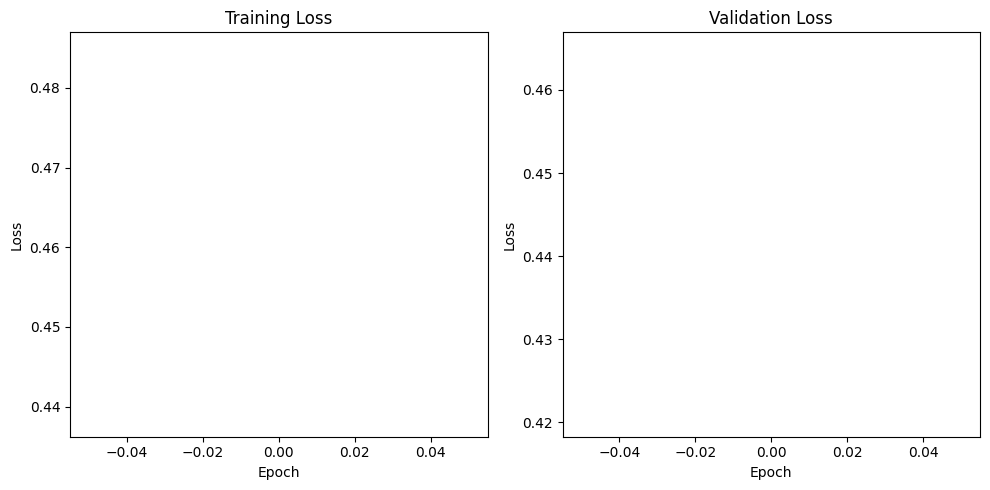

,factors,layers,learning_rate,epochs,batch_size,optimizer,dropout,weight_decay,loss_fn,Hit Ratio@10,NDCG@10,Recall@10
0,8,"[64, 32, 16, 8]",0.0001,1,8192,adam,0.0,0.00010,mse,0.000161,0.000077,0.000147
1,8,"[64, 32, 16, 8]",0.0100,1,8192,sgd,0.0,0.00001,bpr,0.000188,0.000070,0.000175
2,8,"[64, 32, 16, 8]",0.0100,1,4096,adagrad,0.5,0.00001,bce,0.001429,0.000464,0.001377


In [ ]:
tuner.plot_results(results_file=file_path)